In [13]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import optim
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn

import imp
import time
import utils.movie_readin as mru
import utils.plotutils as plu

In [14]:
#movie parameters
movie_dirpath = '/home/vasha/research/datasets/stationary_motion/pixel2xlmomentlens/full_framerate/'
movie_name = 'ocean_only_120.mp4_120fps.mp4'
movie_filepath = movie_dirpath + movie_name
pixel_patchsize = 8
frame_patchsize = 120
maxframes = 960
# read in the movie
#willows = mru.get_movie(movie_filepath, pixel_patchsize, frame_patchsize,
#                          normalize_patch=False, normalize_movie=True, encoding='mp4')
# plot a test movie
#test = willows[10,0,:,:]
#plt.imshow(test)

# hyperparameters
num_epochs = 100
batch_size = 1024
learning_rate = 5e-2
N_TEST_IMG = 5
lambda_activation = 0.5
lambda_biophysical = 0

# model parameters
conv_width = 5
compression = 10
hidden_nodes = int(pixel_patchsize**2 * conv_width / compression)
print(f'Training model:{pixel_patchsize}^2 pixels by {frame_patchsize} frames, to {hidden_nodes} hidden nodes for {compression}x compression')


# make it a Pytorch dataset (inherits from Dataset)
class NaturalMovieDataset(Dataset):
    """Dataset of Stationary Naural Movies"""
    
    def __init__(self, movie_filepath, pixel_patchsize, frame_patchsize,
                     normalize_patch=False, normalize_movie=True, encoding='mp4'):
        """
        Args:
            movie_filepath (string): Path to the movie file
            pixel_patchsize (int): Number of pixels on the edge of a patch
            frame_patchsize (int): Number of frames in the movie
        """
        self.movies = mru.get_movie(movie_filepath, pixel_patchsize, maxframes, frame_patchsize,
                          normalize_patch=normalize_patch, normalize_movie=normalize_movie, encoding='mp4',
                          crop=True)

    def __len__(self):
        return len(self.movies)

    def __getitem__(self, idx):
        movie = self.movies[idx,:,:,:]
        movie = torch.from_numpy(movie)
        sample = Variable(movie)
        return sample

try:
    movie_dataset
except NameError:    
    movie_dataset = NaturalMovieDataset(movie_filepath, pixel_patchsize, frame_patchsize,
                              normalize_patch=False, normalize_movie=True, encoding='mp4')

    train_loader = DataLoader(movie_dataset, batch_size=batch_size,
                            shuffle=True, num_workers=8)

Training model:8^2 pixels by 120 frames, to 32 hidden nodes for 10x compression


In [ ]:
class AEC(nn.Module):
    def __init__(self):
        super(AEC, self).__init__()
        
        temporal_conv_kernel_size = (conv_width, pixel_patchsize, pixel_patchsize)

        self.tconv = nn.utils.weight_norm(nn.Conv3d(1,
                                                   hidden_nodes, 
                                                   kernel_size=temporal_conv_kernel_size,
                                                   stride=1),
                                        name='weight', dim=0)
        
        self.tdeconv = nn.ConvTranspose3d(hidden_nodes,
                                          1,
                                          kernel_size = np.transpose(temporal_conv_kernel_size),
                                          stride=1)

    def encode(self, x):
        activations = F.relu(self.tconv(x))
        return activations

    def decode(self, z):
        recon = self.tdeconv(z)
        return recon

    def forward(self, x):
        activations = self.encode(x)
        #z = self.reparametrize(mu, logvar)
        decoded = self.decode(activations)
        return activations, decoded
    
# our model
model = AEC()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
#scheduler = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)

def loss_func(x, xhat, activations):
        recon_loss = ((x-xhat)**2).mean()
        activation_loss = torch.abs(activations).mean() * lambda_activation
        loss = recon_loss + activation_loss
        return(loss)

print_epocs = 10
    
loss_history = []
print(f'Training {num_epochs} Epochs:')
for i in range(num_epochs):
    start = time.time()
    times = []
    for movie in train_loader:
        movie = torch.unsqueeze(movie,1)
        movie = Variable(movie.float()).cuda()
        optimizer.zero_grad()
        acts = model.encode(movie)
        recon = model.decode(acts)
        loss = loss_func(movie, recon, acts)
        loss_history.append(loss.detach())
        loss.backward()
        optimizer.step()
        end = time.time()
        times.append(end-start)
    if((i+1)%print_epocs==0):
        print(f'{i+1}th Epoch (mean time per epoch: {round(np.mean(times),1)}s)')
    else:
        print('*',end='')
    
print('Done!')
        

Training 100 Epochs:
*********10th Epoch (mean time per epoch: 2.6s)
*********20th Epoch (mean time per epoch: 2.6s)
*********30th Epoch (mean time per epoch: 2.6s)
*********40th Epoch (mean time per epoch: 2.6s)
*******

In [4]:
if(False):
    moreepochs = 100
    print(f'Training for {moreepochs} more Epochs:')
    for i in range(moreepochs):
        start = time.time()
        times = []
        for movie in train_loader:
            movie = torch.unsqueeze(movie,1)
            #print(movie.size())
            movie = Variable(movie.float()).cuda()
            optimizer.zero_grad()
            acts = model.encode(movie)
            recon = model.decode(acts)
            loss = loss_func(movie, recon, acts)
            loss_history.append(loss.detach())
            loss.backward()
            optimizer.step()
            end=time.time()
            times.append(end-start)
        if((i+1)%print_epocs==0):
            print(f'{i+1}th Epoch (mean time per epoch: {round(np.mean(times))}s)')
        else:
            print('*',end='')

    print('Done!')

Training for 100 more Epochs:


Process Process-807:
Process Process-805:
Process Process-808:
Process Process-803:
Process Process-806:
Process Process-804:
Process Process-802:
Process Process-801:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/vasha/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/vasha/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/vasha/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/vasha/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/vasha/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/vasha/anacond

KeyboardInterrupt: 

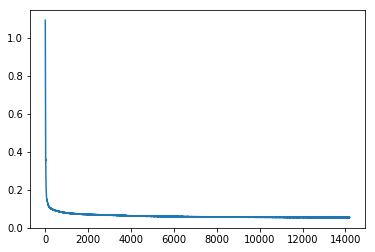

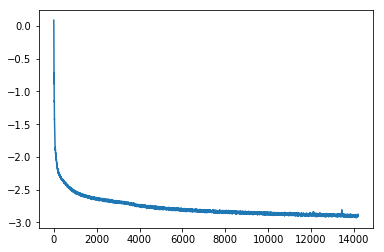

In [10]:
loss_evolution = [np.float(loss.detach()) for loss in loss_history]
plt.plot(loss_evolution)
plt.show()
plt.plot(np.log(loss_evolution))

(32, 5, 8, 8)
(32,)
(32, 5, 8, 8)


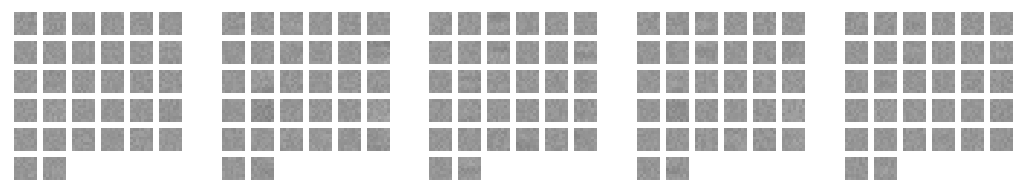

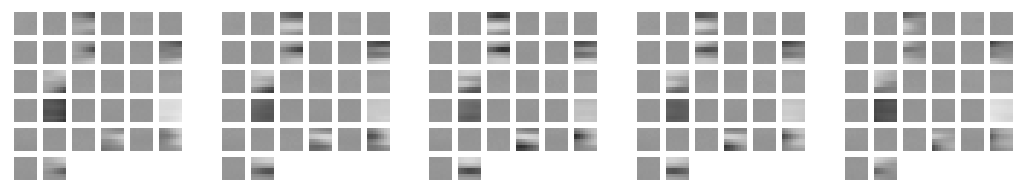

In [11]:
mp = model.parameters()
bias = np.array(next(mp).detach())
wnorm = next(mp)
inw = np.array(next(mp).squeeze().detach())
outw = np.array(next(mp).squeeze().detach())

print(inw.shape)
print(bias.shape)
print(outw.shape)
p = plu.plot_temporal_weights(inw)
p = plu.plot_temporal_weights(outw)

In [ ]:
np.max(inw)
np.min(inw)

Movies:


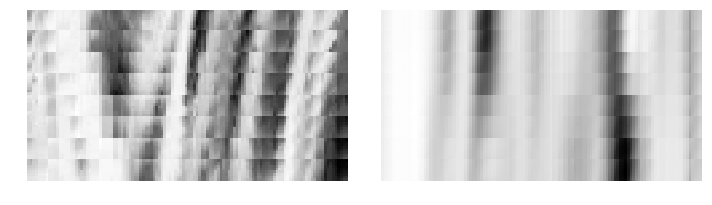

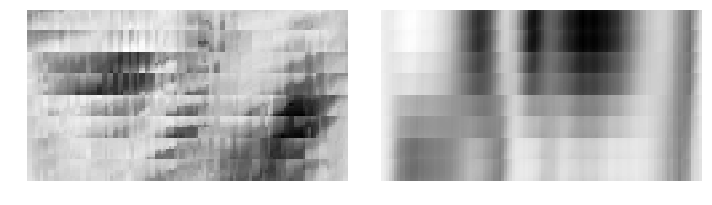

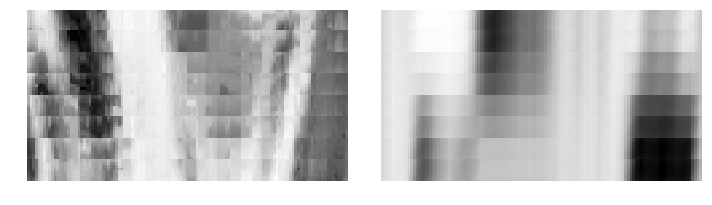

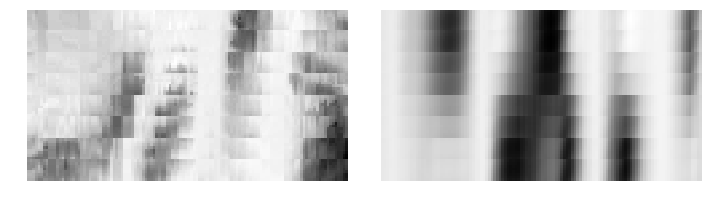

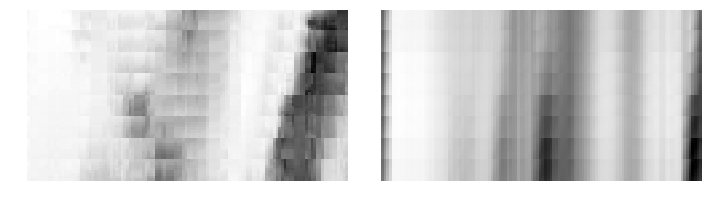

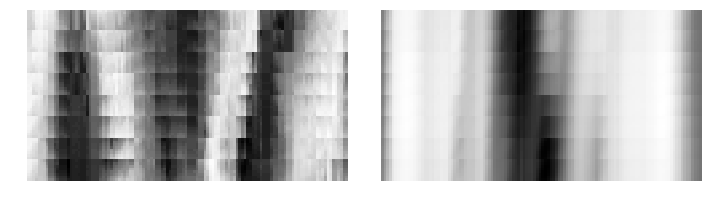

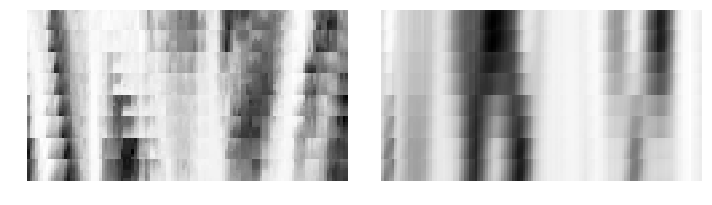

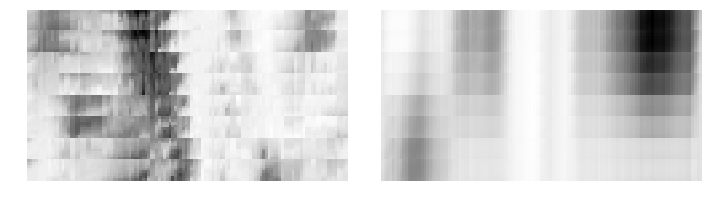

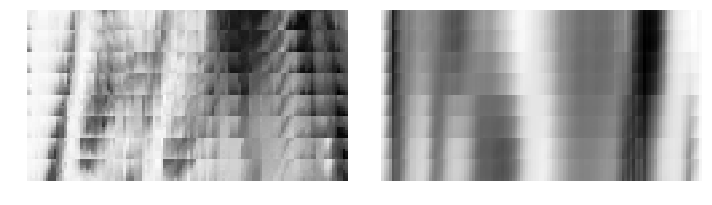

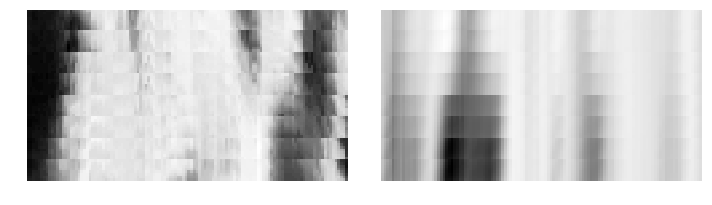

In [7]:
print('Movies:')
for i in range(10):
    plu.plot_movies_recons(np.squeeze(movie), np.squeeze(recon), i)
    #plt.colorbar()
plt.show()


In [ ]:
def visualize_aec():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(train_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.encode(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Recon Images')


visualize_aec()
plt.ioff()
plt.show()

In [ ]:
torchvision.utils.make_grid(input_tensor)

In [ ]:
# initialize figure
f, a = plt.subplots(2, N_TEST_IMG, figsize=(5, 2))
plt.ion()   # continuously plot

# original data (first row) for viewing
view_data = train_data.train_data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)/255.
for i in range(N_TEST_IMG):
    a[0][i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap='gray'); a[0][i].set_xticks(()); a[0][i].set_yticks(())

    
    
for epoch in range(EPOCH):
    for step, (x, b_label) in enumerate(train_loader):
        b_x = x.view(-1, 28*28)   # batch x, shape (batch, 28*28)
        b_y = x.view(-1, 28*28)   # batch y, shape (batch, 28*28)

        encoded, decoded = autoencoder(b_x)

        loss = loss_func(decoded, b_y)      # mean square error
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients

        if step % 100 == 0:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy())

            # plotting decoded image (second row)
            _, decoded_data = autoencoder(view_data)
            for i in range(N_TEST_IMG):
                a[1][i].clear()
                a[1][i].imshow(np.reshape(decoded_data.data.numpy()[i], (28, 28)), cmap='gray')
                a[1][i].set_xticks(()); a[1][i].set_yticks(())
            plt.draw(); plt.pause(0.05)

plt.ioff()
plt.show()

In [ ]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
#
# A simple test procedure to measure STN the performances on MNIST.
#

def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))
    

In [ ]:
model = AEC()
if torch.cuda.is_available():
    model.cuda()